In [1]:
from charm.toolbox.pairinggroup import PairingGroup, ZR, G1, G2, GT, pair
from charm.toolbox.ABEnc import ABEnc
from abenc_tg22 import DIPE_ABE, Inner_Product_TG22
from abenc_ph_mj18 import PH_ABE, mat_math, Inner_Product
from nizk import NIZK
from attack import RogueKeyAtt
from collections import defaultdict 
import time
import matplotlib.pyplot as plt
import numpy as np


/home/guy1m0/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
group_tg = PairingGroup('SS512')
group_mj = PairingGroup('MNT159')
datasets = {}

In [3]:
def benchmark_k(ks, k, n, datasets):

    for assump_size in ks:
        # Pre-processing
        mj = {}
        mj['total'] = 0
        ph_abe = PH_ABE(n, assump_size, group_mj, mat_math())

        nizk = NIZK(group_mj)
        att = RogueKeyAtt(n, assump_size)
        print ('---------------------------------------------------------')
        print ('Setting with n:', n, "k:",assump_size)

        # sys setup
        start_time = time.time()
        pp_mj, _ = ph_abe.setup()
        elapsed_time = time.time() - start_time
        mj['sys'] = elapsed_time
        mj['total'] += elapsed_time


        # Auth setup
        start_time = time.time()
        pks_mj, sks_mj = ph_abe.auth_setup(pp_mj)
        elapsed_time = time.time() - start_time
        mj['auth'] = elapsed_time
        mj['total'] += elapsed_time

        # Key Gen
        GID_mj = group_mj.random(ZR)
        vec_x, vec_v = Inner_Product(group_mj).gen_x_v(n, assump_size)

        start_time = time.time()
        K_mj, _ = ph_abe.keygen(pp_mj, pks_mj, sks_mj, GID_mj, vec_v)
        elapsed_time = time.time() - start_time
        mj['keygen'] = elapsed_time
        mj['total'] += elapsed_time

        # Worst Case verify/prove
        start_time = time.time()
        for i in range(n):
            s_pairs, pis = nizk.prove_pk(pp_mj, pks_mj[str(i+1)], sks_mj[str(i+1)])
        elapsed_time = time.time() - start_time
        mj['prove'] = elapsed_time

        start_time = time.time()
        for i in range(n):
            check = nizk.verify_pk(pp_mj, s_pairs, pis)
            if not check:
                print ("Check not pass for AA:", str(i+1))
                break
        elapsed_time = time.time() - start_time
        mj['verify'] = elapsed_time

        # AD's setup
        start_time = time.time()
        ad = vec_v.index(0) + 1

        ad_vec_v = [0] * (n-1) + [1]
        pks_mj = att.pks_update(ad, pks_mj)
        elapsed_time = time.time() - start_time
        mj['ad_setup'] = elapsed_time
        #print ("Adv's setup: ", elapsed_time)

        # AD KeyGen
        GID_ad = group_mj.random(ZR)
        K_,ad_key_gen = ph_abe.keygen(pp_mj, pks_mj, sks_mj, GID_ad, ad_vec_v, ad=ad)
        mj['ad_keygen'] = ad_key_gen

        # Encryption
        M_mj = group_mj.random(GT)
        start_time = time.time()    
        #print ('M:', M)
        C_mj, vec_s = ph_abe.encrypt(pp_mj, pks_mj, vec_x, M_mj)
        elapsed_time = time.time() - start_time
        mj['encrypt'] = elapsed_time
        mj['total'] += elapsed_time

        # Decryption
        start_time = time.time()
        M_ = ph_abe.decrypt(K_mj, C_mj, vec_v, pp_mj)
        if M_ != M_mj:
            print ('Error in decrypt M (usr): ', M_)
        elapsed_time = time.time() - start_time
        #print ("DU's cost: ", elapsed_time)
        mj['decrypt'] = elapsed_time
        mj['total'] += elapsed_time

        # AD decrypt
        start_time = time.time()
        tmp = ph_abe.decrypt(K_, C_mj, ad_vec_v, pp_mj)
        omega = att.gen_omega(K_,C_mj)
        M_ =  tmp * mat_math().prod(omega)
        if M_ != M_mj:
            print ('Error in decrypt M (adv): ', M_)
        elapsed_time = time.time() - start_time
        mj['ad_cancel_out'] = elapsed_time
        #print ("Ad's cost: ", data['ad_setup'] + data['ad_keygen'] + data['ad_cancel_out'])

        tmp_tg = datasets[f'k_{str(k)}_n_{str(n)}']['tg22']
        print ("MJ's sys cost: ", mj['total'])
        print ("TG's sys cost: ", tmp_tg['total'])
        print ("Enhd sys cost: ", mj['total'] + mj['prove'] + mj['verify'])

        datasets[f'k_{str(assump_size)}_n_{str(n)}']= {'mj18':mj, 'tg22':tmp_tg}

    return datasets

In [4]:
def benchmark(assump_size, n, datasets):

    # Pre-processing
    tg = {}
    mj = {}

    mj['total'] = 0
    tg['total'] = 0
    dipe = DIPE_ABE(n, group_tg)
    ph_abe = PH_ABE(n, assump_size, group_mj, mat_math())

    nizk = NIZK(group_mj)
    att = RogueKeyAtt(n, assump_size)
    print ('---------------------------------------------------------')
    print ('Setting with n:', n, "k:",assump_size)

    # sys setup
    start_time = time.time()
    pp_mj, _ = ph_abe.setup()
    elapsed_time = time.time() - start_time
    mj['sys'] = elapsed_time
    mj['total'] += elapsed_time

    start_time = time.time()
    pp_tg = dipe.setup()
    elapsed_time = time.time() - start_time
    tg['sys'] = elapsed_time
    tg['total'] += elapsed_time


    # Auth setup
    start_time = time.time()
    pks_mj, sks_mj = ph_abe.auth_setup(pp_mj)
    elapsed_time = time.time() - start_time
    mj['auth'] = elapsed_time
    mj['total'] += elapsed_time

    start_time = time.time()
    pks_tg, sks_tg = dipe.auth_setup(pp_tg)
    elapsed_time = time.time() - start_time
    tg['auth'] = elapsed_time
    tg['total'] += elapsed_time

    # Key Gen
    GID_tg = group_tg.random(ZR)
    GID_mj = group_mj.random(ZR)

    vec_x, vec_y = Inner_Product_TG22(group_tg).gen_x_y(n)
    start_time = time.time()
    D0, D1, K_tg = dipe.keygen(pp_tg, sks_tg, GID_tg, vec_x)
    elapsed_time = time.time() - start_time
    tg['keygen'] = elapsed_time
    tg['total'] += elapsed_time

    vec_x, vec_v = Inner_Product(group_mj).gen_x_v(n, assump_size)

    start_time = time.time()
    K_mj, _ = ph_abe.keygen(pp_mj, pks_mj, sks_mj, GID_mj, vec_v)
    elapsed_time = time.time() - start_time
    mj['keygen'] = elapsed_time
    mj['total'] += elapsed_time

    # Worst Case verify/prove
    start_time = time.time()
    for i in range(n):
        s_pairs, pis = nizk.prove_pk(pp_mj, pks_mj[str(i+1)], sks_mj[str(i+1)])
    elapsed_time = time.time() - start_time
    mj['prove'] = elapsed_time

    start_time = time.time()
    for i in range(n):
        check = nizk.verify_pk(pp_mj, s_pairs, pis)
        if not check:
            print ("Check not pass for AA:", str(i+1))
            break
    elapsed_time = time.time() - start_time
    mj['verify'] = elapsed_time

    # AD's setup
    start_time = time.time()
    ad = vec_v.index(0) + 1

    ad_vec_v = [0] * (n-1) + [1]
    pks_mj = att.pks_update(ad, pks_mj)
    elapsed_time = time.time() - start_time
    mj['ad_setup'] = elapsed_time
    #print ("Adv's setup: ", elapsed_time)

    # AD KeyGen
    GID_ad = group_mj.random(ZR)
    K_,ad_key_gen = ph_abe.keygen(pp_mj, pks_mj, sks_mj, GID_ad, ad_vec_v, ad=ad)
    mj['ad_keygen'] = ad_key_gen

    # Encryption
    M_tg = group_tg.random(GT)
    start_time = time.time()
    C_tg = dipe.encrypt(pp_tg, pks_tg, vec_y, M_tg)
    elapsed_time = time.time() - start_time
    tg['encrypt'] = elapsed_time
    tg['total'] += elapsed_time

    M_mj = group_mj.random(GT)
    start_time = time.time()    
    #print ('M:', M)
    C_mj, vec_s = ph_abe.encrypt(pp_mj, pks_mj, vec_x, M_mj)
    elapsed_time = time.time() - start_time
    mj['encrypt'] = elapsed_time
    mj['total'] += elapsed_time

    # Decryption
    start_time = time.time()
    M_ = dipe.decrypt(D0, D1, K_tg, C_tg, vec_y)
    if M_ != M_tg:
        print ('Error in decrypt M (usr): ', M_)
    elapsed_time = time.time() - start_time
    #print ("DU's cost: ", elapsed_time)
    tg['decrypt'] = elapsed_time
    tg['total'] += elapsed_time


    start_time = time.time()
    M_ = ph_abe.decrypt(K_mj, C_mj, vec_v, pp_mj)
    if M_ != M_mj:
        print ('Error in decrypt M (usr): ', M_)
    elapsed_time = time.time() - start_time
    #print ("DU's cost: ", elapsed_time)
    mj['decrypt'] = elapsed_time
    mj['total'] += elapsed_time

    # AD decrypt
    start_time = time.time()
    tmp = ph_abe.decrypt(K_, C_mj, ad_vec_v, pp_mj)
    omega = att.gen_omega(K_,C_mj)
    M_ =  tmp * mat_math().prod(omega)
    if M_ != M_mj:
        print ('Error in decrypt M (adv): ', M_)
    elapsed_time = time.time() - start_time
    mj['ad_cancel_out'] = elapsed_time
    #print ("Ad's cost: ", data['ad_setup'] + data['ad_keygen'] + data['ad_cancel_out'])

    print ("MJ's sys cost: ", mj['total'])
    print ("TG's sys cost: ", tg['total'])
    print ("Enhd sys cost: ", mj['total'] + mj['prove'] + mj['verify'])

    datasets[f'k_{str(assump_size)}_n_{str(n)}']= {'mj18':mj, 'tg22':tg}

    return datasets
    # datasets[str(k)]['n']=data
    # datasets[str(k)]['seq'].append(data)




In [5]:
for n in range(5,36,3):
    datasets = benchmark(2, n, datasets)

---------------------------------------------------------
Setting with n: 5 k: 2
MJ's sys cost:  0.20721054077148438
TG's sys cost:  0.06420230865478516
Enhd sys cost:  0.34946775436401367
---------------------------------------------------------
Setting with n: 8 k: 2
MJ's sys cost:  0.3757491111755371
TG's sys cost:  0.15946316719055176
Enhd sys cost:  0.6050302982330322
---------------------------------------------------------
Setting with n: 11 k: 2
MJ's sys cost:  0.5871179103851318
TG's sys cost:  0.30001282691955566
Enhd sys cost:  0.9009866714477539
---------------------------------------------------------
Setting with n: 14 k: 2
MJ's sys cost:  0.8444275856018066
TG's sys cost:  0.48610758781433105
Enhd sys cost:  1.2379670143127441
---------------------------------------------------------
Setting with n: 17 k: 2
MJ's sys cost:  1.1520907878875732
TG's sys cost:  0.7164855003356934
Enhd sys cost:  1.633970022201538
---------------------------------------------------------
Sett

In [6]:
for n in range(5,36,3):
    datasets = benchmark_k([1], 2, n, datasets)

---------------------------------------------------------
Setting with n: 5 k: 1
MJ's sys cost:  0.14272117614746094
TG's sys cost:  0.06420230865478516
Enhd sys cost:  0.24490618705749512
---------------------------------------------------------
Setting with n: 8 k: 1
MJ's sys cost:  0.27772998809814453
TG's sys cost:  0.15946316719055176
Enhd sys cost:  0.4401395320892334
---------------------------------------------------------
Setting with n: 11 k: 1
MJ's sys cost:  0.46181774139404297
TG's sys cost:  0.30001282691955566
Enhd sys cost:  0.6860580444335938
---------------------------------------------------------
Setting with n: 14 k: 1
MJ's sys cost:  0.6934192180633545
TG's sys cost:  0.48610758781433105
Enhd sys cost:  0.978886604309082
---------------------------------------------------------
Setting with n: 17 k: 1
MJ's sys cost:  0.9667873382568359
TG's sys cost:  0.7164855003356934
Enhd sys cost:  1.3147163391113281
---------------------------------------------------------
Se

In [161]:
import pickle
with open('data_136K_mj18_tg22_enhd.pkl','wb') as file:
    pickle.dump(datasets, file)

## Plots

In [7]:
def plot_entities(xs, ys, labels, label_size=18, legend_size=18):
    # Plotting:
    plt.figure(figsize=(10,6))

    # List of linestyles for variation. You can extend this if needed.
    linestyles = ['-.', '--', '-',':']
    sp_linestyles = ['-.', ':', '-']
    
    # Plotting the regular data points for each k_value
    for y, label, style in zip(ys, labels, linestyles):
        #print (xs, y)
        plt.plot(xs, y, label=f'{label}', linestyle=style)

    # Setting labels, title, legend, etc.
    plt.xlabel('Number of attribute authority', fontsize = label_size)
    plt.ylabel('Elapsed Time (seconds)', fontsize = label_size)
    # plt.title(f'Performance result with fixed k: {k}', fontsize = title_size)
    plt.legend(prop={'size': legend_size})
    plt.grid(True)
    plt.tight_layout()
    #plt.title(title)
    plt.show()

In [8]:
def plot_comp_total(xs, ys, comp_ys, labels,label_size = 18, legend_size = 18):
    plt.figure(figsize=(10, 6))

    linestyles = ['-.','--', ':']

    plt.plot(xs, ys, label=f'Base: {labels[0]}', linestyle='-')

    # Plotting the subsequent data sets and calculating differences for Compare Set 1
    for i, y_,  label, style in zip(range(len(ys)), comp_ys, labels[1:], linestyles):

        plt.plot(xs, y_, label=f'CP{i+1}: {label}', linestyle=style, alpha=0.7)

        plt.fill_between(xs, ys, y_, color='gray', alpha=0.2)

        diff = (np.array(y_) - np.array(ys)) / np.array(ys) * 100
        avg_increase = np.mean(diff)

        # Finding the midpoint for annotation
        mid_index = len(xs) // 2  # Finding the index at the middle of the dataset
        mid_x = xs[mid_index]  # X-coordinate at the midpoint
        mid_y = (ys[mid_index] + y_[mid_index]) / 2  # Average Y-coordinate at the midpoint

        #print (avg_increase, mid_x, mid_y)

        if avg_increase >= 0:
            plt.annotate(f'Avg. increase: {avg_increase:.2f}%', xy=(mid_x, (mid_y+y_[-1])/2), textcoords='data', ha='center', size= 25)
        else:
            plt.annotate(f'Avg. decrease: {-avg_increase:.2f}%', xy=(mid_x, (mid_y+y_[0])/2), textcoords='data', ha='center', size= 25)


    plt.xlabel('Number of attribute authority', fontsize = label_size)
    plt.ylabel('Time Cost (seconds)', fontsize = label_size)
    plt.legend(prop={'size': legend_size})
    plt.grid(True)
    plt.tight_layout()
    #plt.title(title)
    plt.show()

In [9]:
def plot_comp_detail(xs, ys, comp_ys, labels,schemes, show = True, label_size = 18, legend_size = 18):
    plt.figure(figsize=(10, 6))

    linestyles = ['-', '-.','--', ':']

    # Plotting the subsequent data sets and calculating differences for Compare Set 1
    for i, y, y_, label, style in zip(range(len(ys)), ys, comp_ys, labels, linestyles):
        plt.plot(xs, y, label=f'CP{i+1}: {label} of {schemes[0]}', linestyle=style)
        plt.plot(xs, y_, label=f'CP{i+1}: {label} of {schemes[1]}', linestyle=style, alpha=0.7)

        plt.fill_between(xs, y, y_, color='gray', alpha=0.2)

        diff = (np.array(y_) - np.array(y)) / np.array(y) * 100
        avg_increase = np.mean(diff)

        # if avg_increase > 300:
        #     avg_increase = np.mean(diff * np.array(y) / 100)

        # Finding the midpoint for annotation
        mid_index = len(xs) // 2  # Finding the index at the middle of the dataset
        mid_x = xs[mid_index]  # X-coordinate at the midpoint
        mid_y = (y[mid_index] + y_[mid_index]) / 2  # Average Y-coordinate at the midpoint

        if not show:
            continue
        
        if avg_increase >= 0:
            plt.annotate(f'Avg. increase: {avg_increase:.2f}%', xy=(mid_x, (mid_y+y_[-1])/2), textcoords='data', ha='center', size= 25)
        else:
            plt.annotate(f'Avg. decrease: {-avg_increase:.2f}%', xy=(mid_x, (mid_y+y[0])/2), textcoords='data', ha='center', size= 25)

    plt.xlabel('Number of attribute authority', fontsize = label_size)
    plt.ylabel('Time Cost (seconds)', fontsize = label_size)
    plt.legend(prop={'size': legend_size})
    plt.grid(True)
    plt.tight_layout()
    #plt.title(title)
    plt.show()

In [10]:
def time_cost(k, xs, scheme, labels):
    aa = []
    do = []
    du = []

    sys = []
    au = []
    kg = []

    for n in xs:
        #print (f'k_{str(k)}_n_{str(n)}')
        
        if scheme == 'enhd':
            d = datasets[f'k_{str(k)}_n_{str(n)}']['mj18']
            aa.append((d['auth'] + d['keygen']+d['prove'])/n)
        else:
            d = datasets[f'k_{str(k)}_n_{str(n)}'][scheme]
            aa.append((d['auth'] + d['keygen'])/n)

        do.append(d['encrypt'])
        du.append(d['decrypt'])
        sys.append(d['sys'])
        if scheme == 'enhd':
            au.append(d['auth'] + d['prove'] + d['verify'])
        else:
            au.append(d['auth'])
        kg.append(d['keygen'])

    ret = []



    if 'Sys Setup' in labels:
        ret.append(sys)

    if 'Auth Setup' in labels:
        ret.append(au)

    if 'Key Gen' in labels:
        ret.append(kg)

    if 'Attribute Authority' in labels:
        ret.append(aa)

    if 'Data Owner' in labels or 'Encryption' in labels:
        ret.append(do)

    if 'Data User' in labels or 'Decryption' in labels:
        ret.append(du)

    return ret

### Detail (Entity & Step)

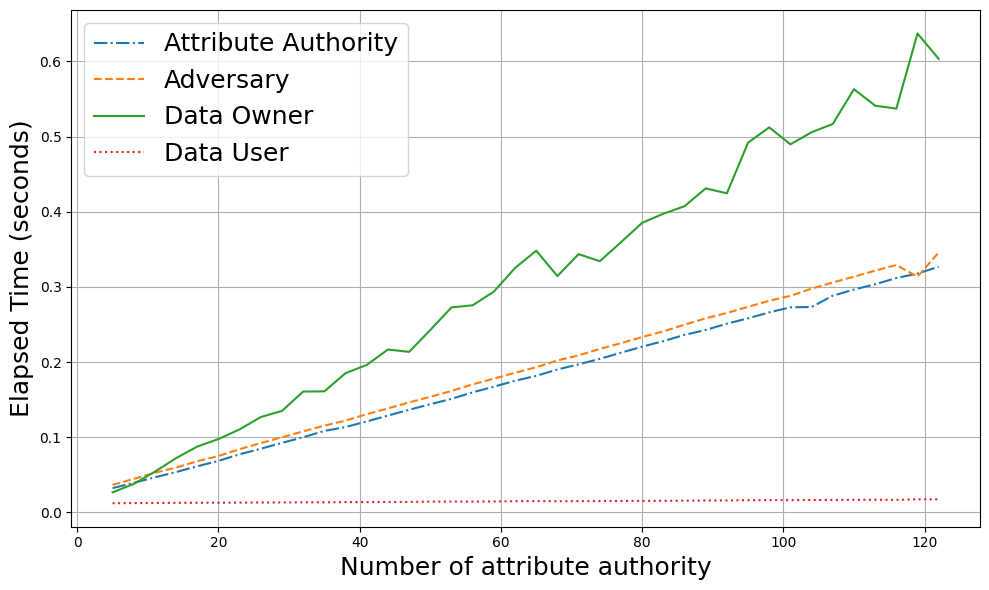

In [84]:
k = 2
xs = range(5,125,3)
aa = []
do = []
du = []
ad = []
labels = ['Attribute Authority', 'Adversary', 'Data Owner', 'Data User']

for n in xs:
    d = datasets[f'k_{str(k)}_n_{str(n)}']['mj18']
    aa.append((d['auth'] + d['keygen'])/n)
    ad.append(d['ad_setup'] + d['ad_cancel_out'] + d['ad_keygen'])
    do.append(d['encrypt'])
    du.append(d['decrypt'])

plot_entities(xs, [aa,ad, do,du], labels)

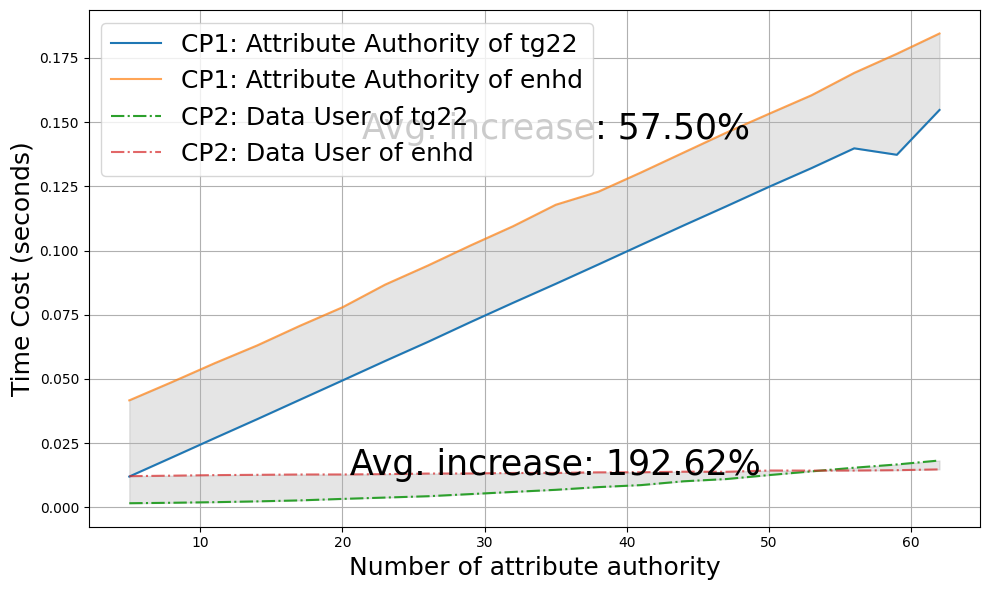

In [62]:
labels = ['Attribute Authority','Data User']
schemes = ['tg22','enhd']
xs = range(5,65,3)
k = 2
ys = []
comp_ys = []

for y, y_ in zip(time_cost(k, xs, schemes[0],labels), time_cost(k, xs, schemes[1],labels)):
    ys.append(y)
    comp_ys.append(y_)

plot_comp_detail(xs, ys, comp_ys, labels, schemes)

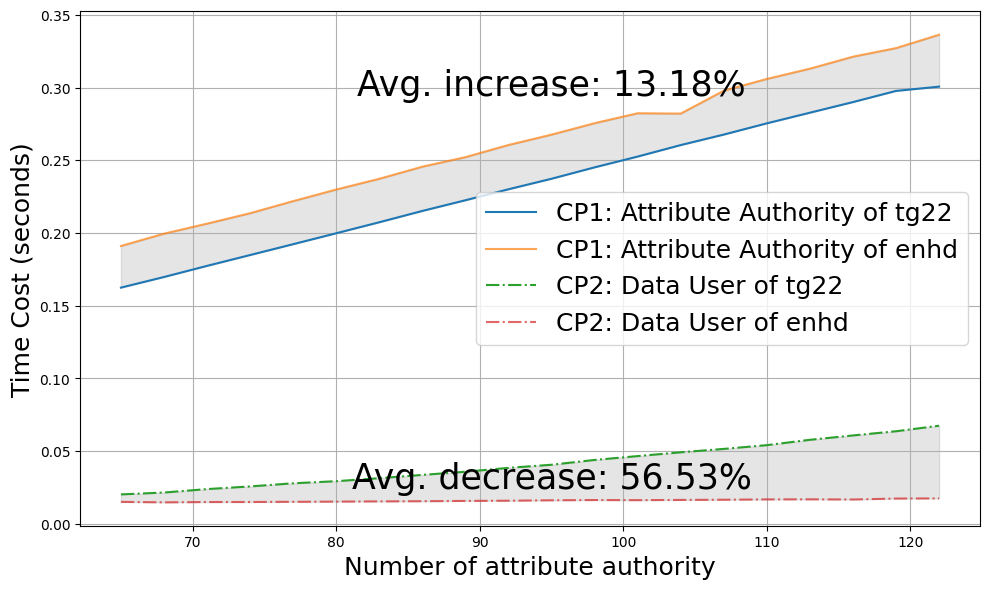

In [61]:
labels = ['Attribute Authority','Data User']
schemes = ['tg22','enhd']
xs = range(65,125,3)
k = 2
ys = []
comp_ys = []

for y, y_ in zip(time_cost(k, xs, schemes[0],labels), time_cost(k, xs, schemes[1],labels)):
    ys.append(y)
    comp_ys.append(y_)

plot_comp_detail(xs, ys, comp_ys, labels, schemes)

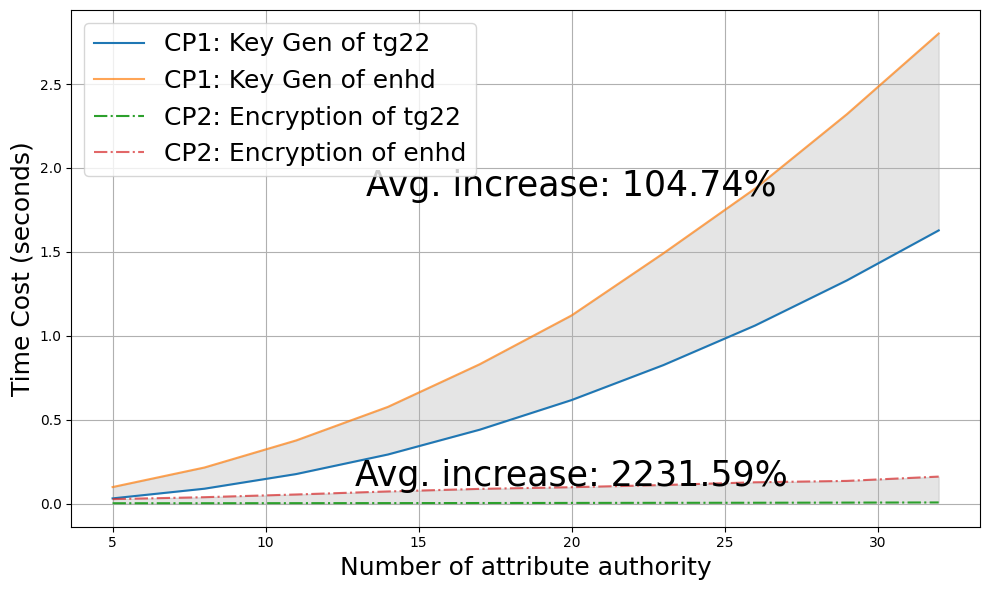

In [151]:
labels = ['Key Gen','Encryption']
schemes = ['tg22','enhd']
xs = range(5,35,3)
k = 2
ys = []
comp_ys = []

for y, y_ in zip(time_cost(k, xs, schemes[0],labels), time_cost(k, xs, schemes[1],labels)):
    ys.append(y)
    comp_ys.append(y_)

plot_comp_detail(xs, ys, comp_ys, labels, schemes)

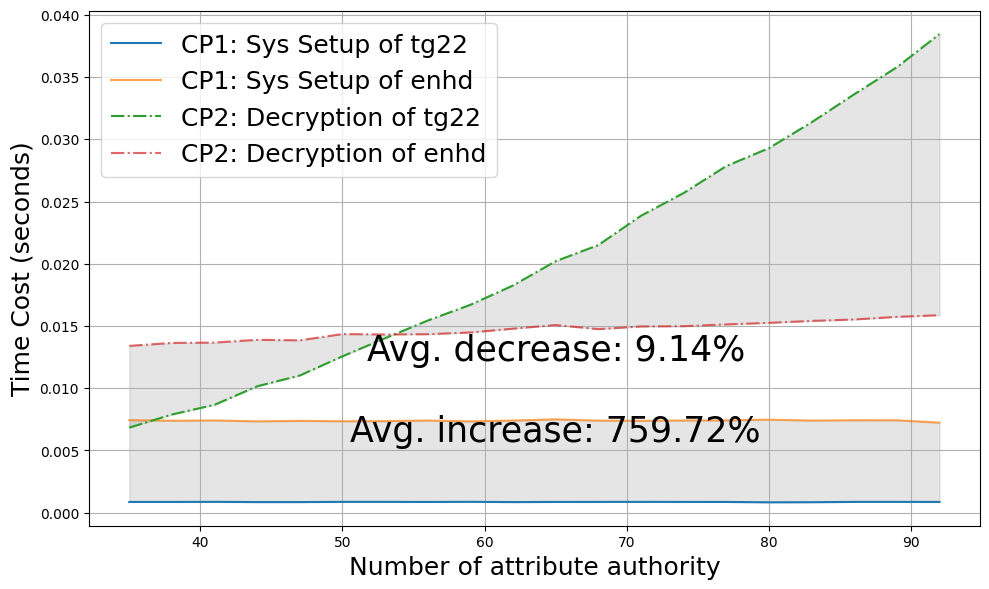

In [138]:
labels = ['Sys Setup','Decryption']
schemes = ['tg22','enhd']
xs = range(35,95,3)
k = 2
ys = []
comp_ys = []

for y, y_ in zip(time_cost(k, xs, schemes[0],labels), time_cost(k, xs, schemes[1],labels)):
    ys.append(y)
    comp_ys.append(y_)

plot_comp_detail(xs, ys, comp_ys, labels, schemes)

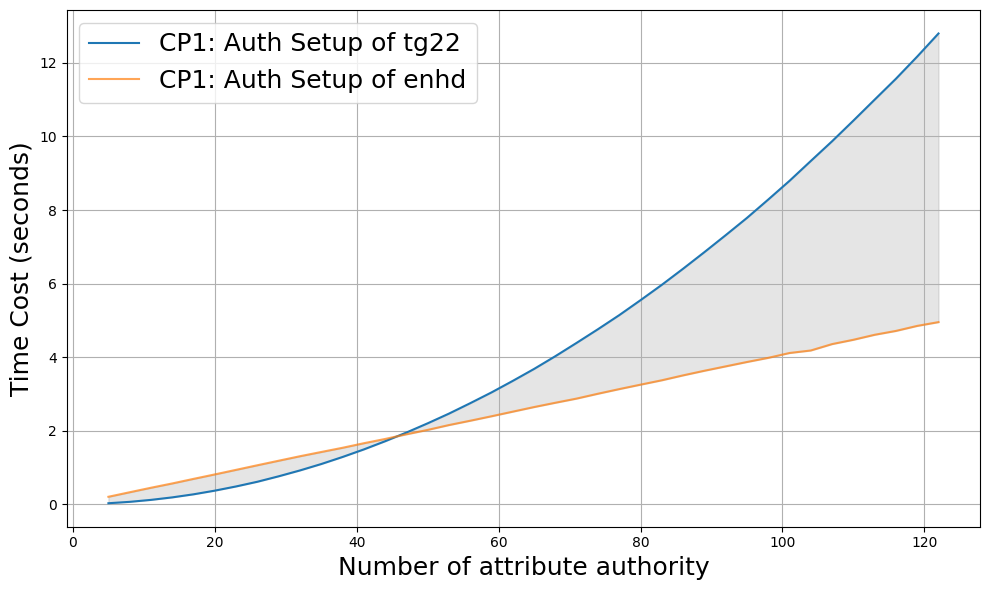

In [85]:
labels = ['Auth Setup']
schemes = ['tg22','enhd']
xs = range(5,125,3)
k = 2
ys = []
comp_ys = []

for y, y_ in zip(time_cost(k, xs, schemes[0],labels), time_cost(k, xs, schemes[1],labels)):
    ys.append(y)
    comp_ys.append(y_)

plot_comp_detail(xs, ys, comp_ys, labels, schemes,show=False)

### Total time

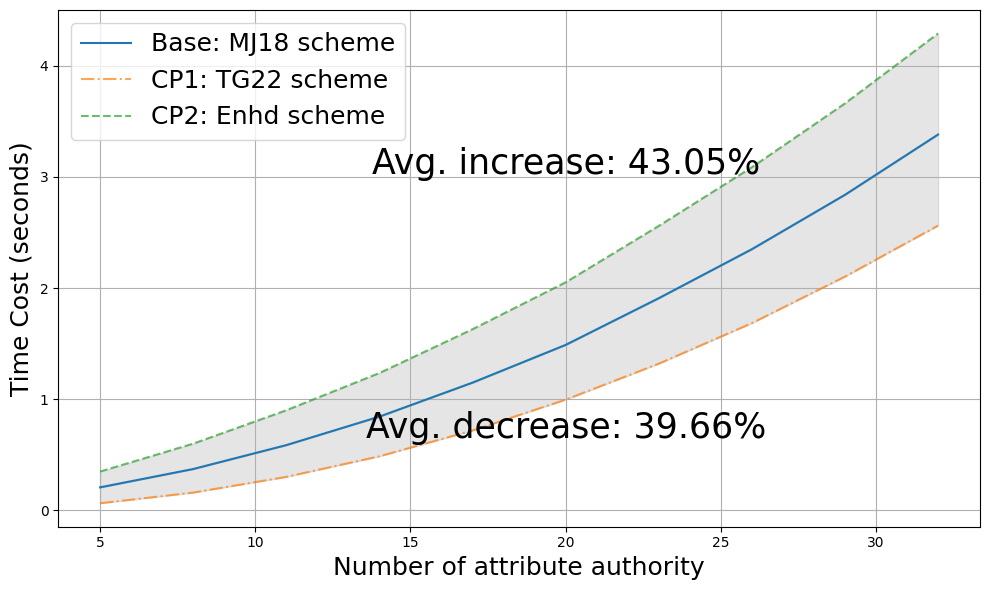

In [48]:
k = 2
xs = range(5,35,3)
comp1 = []
comp2 = []
base = []

for n in xs:
    data = datasets[f'k_{str(k)}_n_{str(n)}']
    base.append(data['mj18']['total'])
    comp1.append(data['tg22']['total'])
    comp2.append(data['mj18']['total'] + data['mj18']['prove'] + data['mj18']['verify'])

plot_comp_total(xs, base, [comp1, comp2], ['MJ18 scheme', 'TG22 scheme', 'Enhd scheme'])

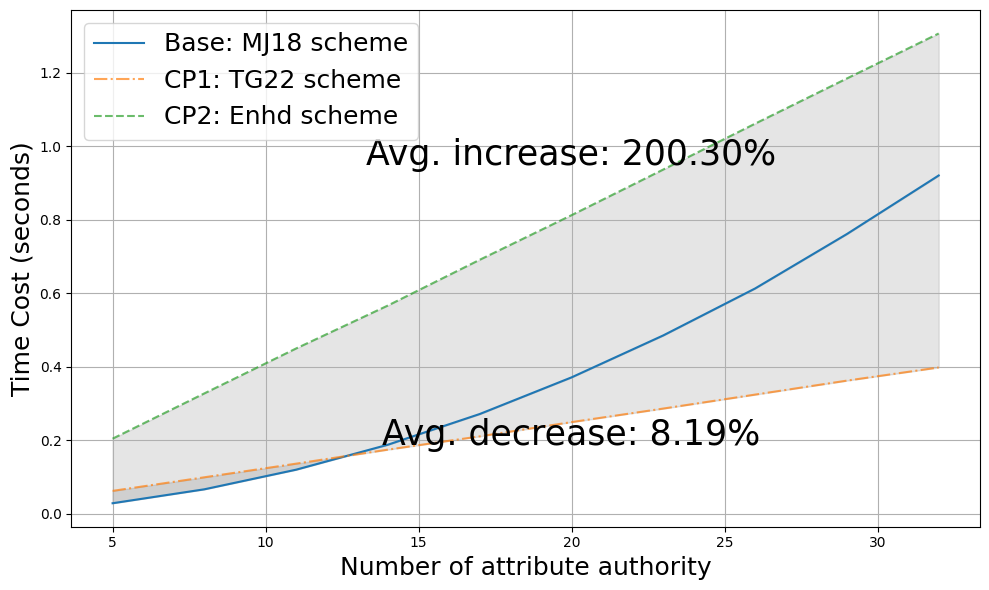

In [104]:
k = 2
xs = range(5,35,3)
comp1 = []
comp2 = []
base = []

for n in xs:
    data = datasets[f'k_{str(k)}_n_{str(n)}']
    base.append(data['tg22']['auth'])
    comp1.append(data['mj18']['auth'])
    comp2.append(data['mj18']['auth'] + data['mj18']['prove'] + data['mj18']['verify'])

plot_comp_total(xs, base, [comp1, comp2], ['TG22 scheme', 'MJ18 scheme', 'Enhd scheme'])

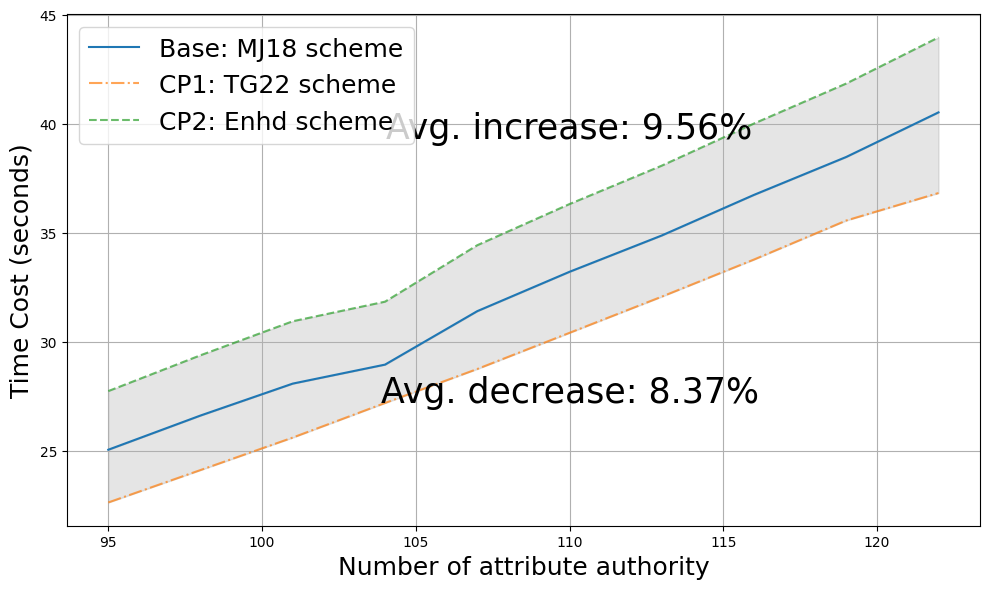

In [105]:
k = 2
xs = range(95,125,3)
comp1 = []
comp2 = []
base = []

for n in xs:
    data = datasets[f'k_{str(k)}_n_{str(n)}']
    base.append(data['mj18']['total'])
    comp1.append(data['tg22']['total'])
    comp2.append(data['mj18']['total'] + data['mj18']['prove'] + data['mj18']['verify'])

plot_comp_total(xs, base, [comp1, comp2], ['MJ18 scheme', 'TG22 scheme', 'Enhd scheme'])

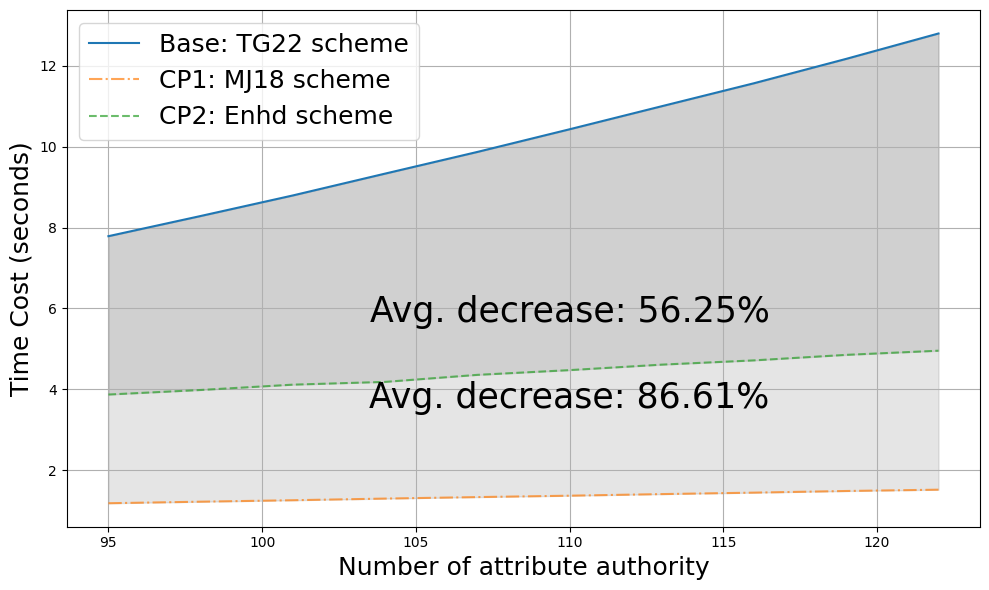

In [103]:
k = 2
xs = range(95,125,3)
comp1 = []
comp2 = []
base = []

for n in xs:
    data = datasets[f'k_{str(k)}_n_{str(n)}']
    base.append(data['tg22']['auth'])
    comp1.append(data['mj18']['auth'])
    comp2.append(data['mj18']['auth'] + data['mj18']['prove'] + data['mj18']['verify'])

plot_comp_total(xs, base, [comp1, comp2], ['TG22 scheme', 'MJ18 scheme', 'Enhd scheme'])